In [11]:
import sys
import numpy as np
sys.path.append('../../../nn')

# import mynn
from mynn import *

N_θ = 100

prefix = "../"
θ = np.load(prefix+"Random_Helmholtz_theta_" + str(N_θ) + ".npy")   
κ = np.load(prefix+"Random_Helmholtz_K_" + str(N_θ) + ".npy")


θ_train, κ_train = θ[0::2, :], κ[:, :,  0::2]
θ_test, κ_test = θ[1::2, :], κ[:, :,  1::2]

# Scale the training data
coeff_scale = 1.0
# load data 

N_data, N_θ  =  θ_train.shape
N_x, N_y, N_data = κ_train.shape

N_upper = (N_x*(N_y+1) // 2)
L = 1.0
assert(N_x == N_y)
Δx = L/(N_x - 1)

input_train  = np.zeros((N_data * N_upper, (N_θ + 2)), dtype=np.float32) # θ, x, y
output_train = np.zeros((N_data * N_upper), dtype=np.float32)

xx = np.linspace(0, L, N_x)
Y, X = np.meshgrid(xx, xx)

# test
i = 20
j = 40
assert(X[i, j] == i*Δx and Y[i, j] == j*Δx)

X_upper = full2upper(X)
Y_upper = full2upper(Y)

for i in range(N_data):
    d_range = range(i*N_upper, (i + 1)*N_upper)
    input_train[d_range , 0:N_θ]   = θ_train[i]
    input_train[d_range , N_θ]     = X_upper
    input_train[d_range , N_θ + 1] = Y_upper 
    output_train[d_range] = full2upper(κ_train[:, :, i]) * coeff_scale
    



x_train = torch.from_numpy(input_train) 
y_train = torch.from_numpy(output_train).unsqueeze(-1)


ds = DirectData(X=x_train, y=y_train)
ds = DataLoader(ds, batch_size=256, shuffle=True)

In [20]:
# TODO change to DirectNet_50
N_neurons = 20

if N_neurons == 20:
    DirectNet = DirectNet_20
elif N_neurons == 50:
    DirectNet = DirectNet_50


model = DirectNet(N_θ + 2, 1)
# model = torch.load("DirectNet_"+str(N_neurons)+".model")

loss_fn = torch.nn.MSELoss(reduction='sum')


learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)

n_epochs = 50
for epoch in range(n_epochs):
    
    for ix, (_x, _y) in enumerate(ds):
    
        
        # Forward pass: compute predicted y by passing x to the model.
        y_pred = model(_x)

        # Compute and print loss.
        loss = loss_fn(y_pred, _y)

        # Before the backward pass, use the optimizer object to zero all of the
        # gradients for the variables it will update (which are the learnable
        # weights of the model). This is because by default, gradients are
        # accumulated in buffers( i.e, not overwritten) whenever .backward()
        # is called. Checkout docs of torch.autograd.backward for more details.
        optimizer.zero_grad()

        # Backward pass: compute gradient of the loss with respect to model
        # parameters
        loss.backward()

        # Calling the step function on an Optimizer makes an update to its
        # parameters
        optimizer.step()
        
    if epoch % 10 == 0:
        print("[{}/{}], loss: {}".format(epoch, n_epochs, np.round(loss.item(), 3)))
        torch.save(model, "DirectNet_"+str(N_neurons)+".model")

	
# save the model
torch.save(model, "DirectNet_"+str(N_neurons)+".model")


[0/50], loss: 12.571
[10/50], loss: 7.557
[20/50], loss: 7.659
[30/50], loss: 1.953
[40/50], loss: 0.981


# Test on the training data

Averaged train error is  0.24182025379340547


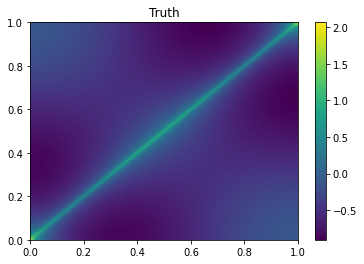

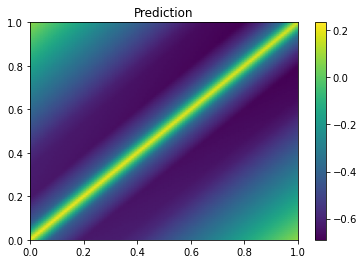

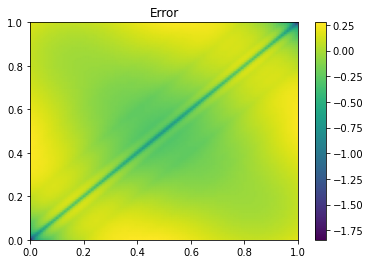

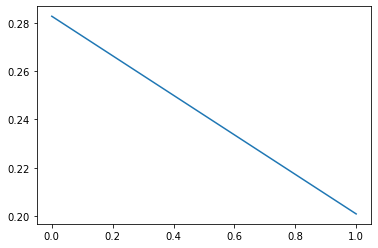

In [21]:
N_data_train, N_θ  =  θ_train.shape

output_train = model(torch.from_numpy(input_train))
κ_pred_upper = output_train.detach().numpy() / coeff_scale

κ_pred = upper2full(κ_pred_upper, N_data_train)

errors = np.zeros(N_data_train)

plot_freq = 249

for train_id in np.arange(0, N_data_train):

    errors[train_id] =  np.linalg.norm(κ_pred[:, :, train_id] - κ_train[:, :, train_id])/np.linalg.norm(κ_train[:, :, train_id])
    
    if train_id % plot_freq == 0:
        # vmin, vmax = np.min(κ_train[:, :, train_id]), np.max(κ_train[:, :, train_id])
        
        vmin, vmax = None, None
        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_train[:, :, train_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Truth")
        fig.savefig("Truth_%04i.png" % train_id)

        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_pred[:, :, train_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Prediction")
        fig.savefig("Prediction_%04i.png" % train_id)
        
        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_pred[:, :, train_id] - κ_train[:, :, train_id], shading="gouraud")
        plt.colorbar()
        plt.title("Error")
        fig.savefig("Error_%04i.png" % train_id)
        
        

print("Averaged train error is ", np.average(errors))
fig = plt.figure()
plt.plot(errors)
fig.savefig("Error.png")



# Test on the test data

Averaged test error is  1.4839402149522058


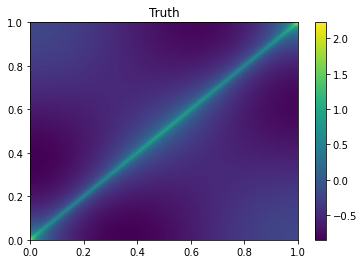

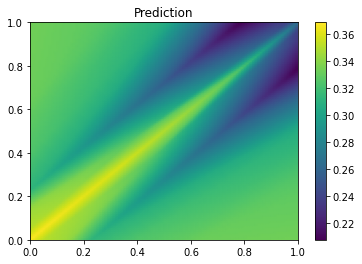

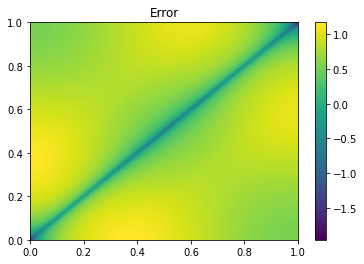

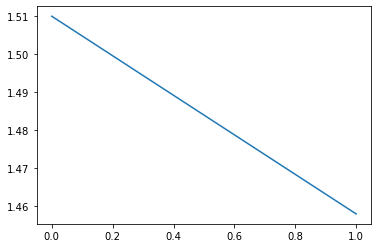

In [22]:
N_data_test = len(θ_test)
input_test = np.zeros((N_data_test*N_upper, (N_θ + 2)), dtype=np.float32) # θ, x, y

for i in range(N_data_test):
    d_range = range(i*N_upper, (i + 1)*N_upper)
    input_test[d_range , 0:N_θ] = θ_test[i]
    input_test[d_range , N_θ] = X_upper
    input_test[d_range , N_θ + 1] = Y_upper 
    


output_test = model(torch.from_numpy(input_test))
κ_pred_upper = output_test.detach().numpy() / coeff_scale

κ_pred = upper2full(κ_pred_upper, N_data_test)

plot_freq = 249

errors = np.zeros(N_data_test)
for test_id in np.arange(0, N_data_test):

    errors[test_id] =  np.linalg.norm(κ_pred[:, :, test_id] - κ_test[:, :, test_id])/np.linalg.norm(κ_test[:, :, test_id])
    
    if test_id % plot_freq == 0:
        # vmin, vmax = np.min(κ_test[:, :, test_id]), np.max(κ_test[:, :, test_id])
        
        vmin, vmax = None, None
        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_test[:, :, test_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Truth")
        fig.savefig("Truth_%04i.png" % test_id)

        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_pred[:, :, test_id], shading="gouraud", vmin=vmin, vmax=vmax)
        plt.colorbar()
        plt.title("Prediction")
        fig.savefig("Prediction_%04i.png" % test_id)
        
        fig = plt.figure()
        plt.pcolormesh(X, Y, κ_pred[:, :, test_id] - κ_test[:, :, test_id], shading="gouraud")
        plt.colorbar()
        plt.title("Error")
        fig.savefig("Error_%04i.png" % test_id)
        
        

print("Averaged test error is ", np.average(errors))
fig = plt.figure()
plt.plot(errors)
fig.savefig("Error.png")
